# Segmenting and Clustering Neighborhoods in London

The idea of this notebook is taking from Manhanta's notebook used in Coursera. 

## 1. Importing libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
from pandas.io.json import json_normalize # library to handle JSON files
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium 
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



## 2. Download Data

In [2]:
path = '/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/'

london_postcode = pd.read_csv(path + 'London postcodes.csv')

In [3]:
london_postcode = london_postcode.drop(['Postcode', 'In Use?','Easting', 'Northing',
       'Grid Ref', 'County', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced','Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban','Region', 'Altitude','LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code','Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station','Postcode area','Police force','Water company', 'Plus Code'], axis=1)

In [4]:
london_postcode.head()

,Latitude,Longitude,District,Ward,London zone,Postcode district,Average Income
0,51.401546,0.015415,Bromley,Bromley Town,5,BR1,63100
1,51.406333,0.015208,Bromley,Bromley Town,4,BR1,56100
2,51.400057,0.016715,Bromley,Bromley Town,5,BR1,63100
3,51.404543,0.014195,Bromley,Bromley Town,4,BR1,63100
4,51.401392,0.014948,Bromley,Bromley Town,5,BR1,63100


In [5]:
london_postcode = london_postcode[london_postcode['London zone']<=3]

In [6]:
# More than one neighborhood can exist in one postal code area.
df = london_postcode[['District','Ward']].drop_duplicates()
df = df.groupby(['District'])['Ward'].apply(lambda x: ', '.join(x))
df = df.reset_index()


In [7]:
lati_long_df = london_postcode.groupby(['District','Ward'])['Latitude', 'Longitude'].mean()
average_income_df = london_postcode.groupby(['District','Ward'])['Average Income'].mean().to_frame()

In [8]:
lati_long_df.reset_index(inplace=True) 
average_income_df.reset_index(inplace=True) 

In [9]:
#aux_pd['Postcode district'] = aux_pd.index
lati_long_df['Latitude_avg'] = lati_long_df['Latitude']
lati_long_df['Longitude_avg'] = lati_long_df['Longitude']
lati_long_df = lati_long_df.drop(['Latitude', 'Longitude'], axis=1)



In [10]:
london_postcode_aux = london_postcode[['District','Ward']].drop_duplicates()
london_postcode_df = pd.merge(london_postcode_aux, lati_long_df, on=['District','Ward'])

In [11]:
print('shape:',london_postcode_df.shape)
london_postcode_df.head()

shape: (399, 4)


,District,Ward,Latitude_avg,Longitude_avg
0,Lewisham,Whitefoot,51.435314,-0.005240
1,Lambeth,Streatham South,51.416389,-0.132432
2,Bromley,Darwin,51.321934,0.035867
3,Bromley,Penge and Cator,51.410205,-0.052140
4,Bromley,Clock House,51.406121,-0.050188


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(london_postcode_df['District'].unique()),
        london_postcode_df.shape[0]
    )
)

The dataframe has 29 boroughs and 399 neighborhoods.


In [13]:
# create map of Toronto using latitude and longitude values
latitude = 51.509865 #they are latitude and longitude of London
longitude = -0.118092
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, postcode in zip(london_postcode_df['Latitude_avg'],london_postcode_df['Longitude_avg'], london_postcode_df['District'], london_postcode_df['Ward']):
    label = '{}, {}'.format(district, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## 3.  Explore Neighborhoods
### Define Foursquare Credentials and Version

In [14]:
# @hidden_cell
CLIENT_ID  = '114NZNSDLZPAK0OJ55IWBXFFJBSGCNZBQBUYDQ4RBNSHSHWN'
CLIENT_SECRET = 'IQXB50UD15YPSB5YV0Q3HRCL0UFMBW2CIG1LPZATQ4INQRTA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


#### Now, let's get the top 100 venues that are in all neighborhood from London within a radius of 500 meters.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
LIMIT = 100
radius = 500
London_venues = getNearbyVenues(names=london_postcode_df['Ward'],
                                   latitudes=london_postcode_df['Latitude_avg'],
                                   longitudes=london_postcode_df['Longitude_avg']
                                  )

Whitefoot
Streatham South
Darwin
Penge and Cator
Clock House
Hayes and Coney Hall
West Wickham
King's Cross
New Addington South
New Addington North
Fairfield
Broad Green
Waddon
West Thornton
Beddington North
Shirley South
Selsdon & Addington Village
Park Hill & Whitgift
Shirley North
Addiscombe West
South Croydon
Addiscombe East
Woodside
Selsdon Vale & Forestdale
Biggin Hill
Longthornton
Cricket Green
Pollards Hill
Figge's Marsh
Graveney
Lavender Fields
Colliers Wood
Ravensbury
Norbury & Pollards Hill
Bensham Manor
Norbury Park
Shadwell
Whitechapel
St Dunstan's
Stepney Green
Spitalfields & Banglatown
Bethnal Green
St Peter's
Bishopsgate
Hoxton East & Shoreditch
Weavers
Portsoken
Aldgate
Tower
St Katharine's & Wapping
Leyton
Grove Green
Cathall
Forest
Hoe Street
Lea Bridge
Markhouse
Leytonstone
Wanstead Village
Wanstead Park
Cann Hall
Stratford and New Town
Manor Park
Little Ilford
East Ham North
Wall End
Plaistow North
West Ham
Plaistow South
Canning Town North
Green Street West
Cannin

In [17]:
london_postcode_df = london_postcode_df.rename(columns = {'District':'Borough','Ward':'Neighborhood'})


In [18]:
London_venues = pd.merge(London_venues,london_postcode_df, on=['Neighborhood'])

London_venues = London_venues.drop(['Latitude_avg', 'Longitude_avg'], axis=1)

London_venues = London_venues.dropna()


## 4. EDA
Now, we have the dataframe which contains all information about the Borough, Neighbourhoods and Venues from New York, therefore, we are going to analyse this data.

In [19]:
print(London_venues.shape)

London_venues.head()

(12256, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,Whitefoot,51.435314,-0.005240,Forster Memorial Park,51.432501,-0.006566,Park,Lewisham
1,Whitefoot,51.435314,-0.005240,Mumbai Express,51.434374,-0.005214,Indian Restaurant,Lewisham
2,Whitefoot,51.435314,-0.005240,The Prefab Museum,51.434847,-0.001539,History Museum,Lewisham
3,Streatham South,51.416389,-0.132432,The Railway,51.418492,-0.134820,Gastropub,Lambeth
4,Streatham South,51.416389,-0.132432,The Bull,51.419354,-0.128208,Pub,Lambeth


#### Firstly, we are going to see how many Neightbourhoods are for each Borough.

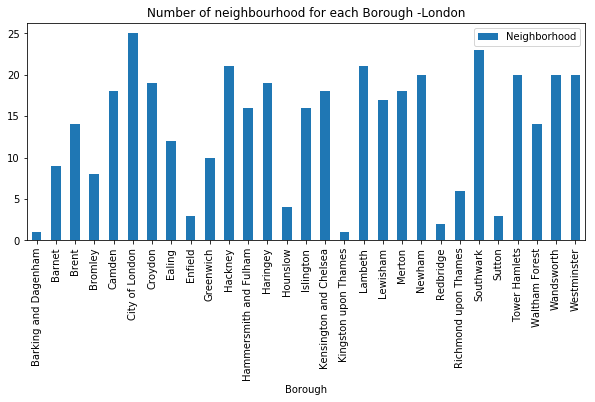

In [20]:
fig, axs = plt.subplots(1,figsize=(10,4))
London_venues.groupby(['Borough'])['Neighborhood'].nunique().to_frame().plot.bar(ax = axs)
plt.title('Number of neighbourhood for each Borough -London')
plt.show()
fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/London_Borough.png')

Let's check what type of Venues is in Dataframe

In [21]:
text = sorted(list(London_venues['Venue Category'].values))

In [22]:
text = ['_'.join(i.split()) for i in text]

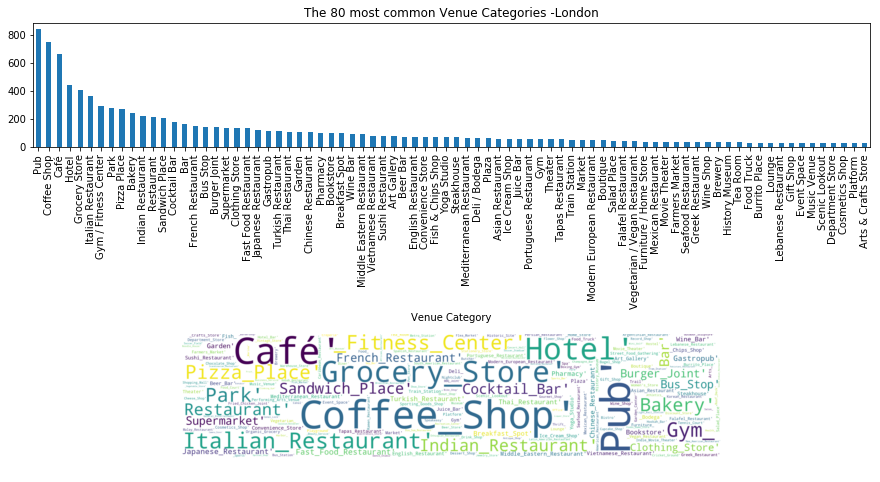

In [23]:
fig, axs = plt.subplots(2,1,figsize=(15,8))
plt.subplots_adjust(hspace=1.5)
aux_df = London_venues.groupby(['Venue Category'])['Venue Category'].count().sort_values(ascending=False)
aux_df[0:80].plot.bar(ax=axs[0])
axs[0].set_title('The 80 most common Venue Categories -London')

stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white",width=2600, height=600, collocations=False,stopwords = stopwords)
wc.generate(str(text))
axs[1].imshow(wc, interpolation='bilinear')

axs[1].axis("off")

plt.show()

fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/London_venues.png')


Let's check how many venues were returned for each neighborhood

In [24]:
London_venues.groupby(['Borough','Neighborhood'])['Venue'].count().to_frame()

Venue
Borough              Neighborhood         
Barking and Dagenham Thames              1
Barnet               Childs Hill         4
                     Colindale          12
                     Coppetts            9
                     East Finchley      23
...                                    ...
Westminster          Tachbrook          34
                     Vincent Square     93
                     Warwick           100
                     West End          100
                     Westbourne         13

[398 rows x 1 columns]

#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 400 uniques categories.


### 4.1. Analyze each Neighborhood

In [26]:
# one hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = London_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo Exhibit
0,Whitefoot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Whitefoot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Whitefoot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Streatham South,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Streatham South,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#shape
london_onehot.shape

(12256, 401)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo Exhibit
0,Abbey,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Abbey Road,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.038462,0.0
2,Abingdon,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.024390,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Acton Central,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Addiscombe East,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Woodberry Down,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
384,Woodside,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
385,Woolwich Common,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
386,Woolwich Riverside,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey----
              venue  freq
0               Bar   0.1
1  Sushi Restaurant   0.1
2     Grocery Store   0.1
3       Coffee Shop   0.1
4              Café   0.1


----Abbey Road----
                       venue  freq
0                       Café  0.08
1              Deli / Bodega  0.08
2                Coffee Shop  0.08
3           Recording Studio  0.04
4  Middle Eastern Restaurant  0.04


----Abingdon----
                venue  freq
0                Café  0.10
1  Italian Restaurant  0.07
2                 Pub  0.07
3      Clothing Store  0.07
4        Cupcake Shop  0.05


----Acton Central----
             venue  freq
0    Grocery Store  0.22
1            Hotel  0.22
2    Train Station  0.11
3   Breakfast Spot  0.11
4  Bed & Breakfast  0.11


----Addiscombe East----
                  venue  freq
0         Grocery Store  0.15
1                Bakery  0.15
2                  Park  0.15
3  Fast Food Restaurant  0.15
4     Indian Restaurant  0.08


----Addiscombe West----
      

                 venue  freq
0                 Café  0.11
1   Italian Restaurant  0.07
2                Hotel  0.04
3  Japanese Restaurant  0.04
4               Garden  0.03


----Brondesbury Park----
                   venue  freq
0                 Hostel  0.25
1   Gym / Fitness Center  0.25
2                    Pub  0.25
3                   Park  0.25
4  Outdoors & Recreation  0.00


----Brownswood----
         venue  freq
0         Café  0.18
1        Hotel  0.12
2          Pub  0.09
3  Coffee Shop  0.06
4  Pizza Place  0.06


----Bruce Grove----
                  venue  freq
0                   Pub  0.19
1  Fast Food Restaurant  0.12
2            Hookah Bar  0.06
3           Roller Rink  0.06
4         Grocery Store  0.06


----Bryanston and Dorset Square----
                       venue  freq
0  Middle Eastern Restaurant  0.07
1                Coffee Shop  0.07
2                      Hotel  0.06
3                       Café  0.04
4        Lebanese Restaurant  0.04


----Bunhill---

                venue  freq
0         Coffee Shop  0.14
1                Café  0.08
2  Italian Restaurant  0.06
3         Pizza Place  0.06
4           Gastropub  0.06


----Custom House----
                  venue  freq
0       Bed & Breakfast  0.14
1  Fast Food Restaurant  0.14
2           Bus Station  0.14
3      Tapas Restaurant  0.14
4    Light Rail Station  0.14


----Dalgarno----
                  venue  freq
0                  Park  0.25
1        Breakfast Spot  0.12
2  Gym / Fitness Center  0.12
3           Supermarket  0.12
4         Grocery Store  0.12


----Dalston----
                venue  freq
0                Café  0.06
1  Turkish Restaurant  0.05
2       Grocery Store  0.05
3                 Pub  0.04
4          Restaurant  0.04


----Darwin----
                        venue  freq
0  Construction & Landscaping  0.25
1            Airport Terminal  0.25
2                      Museum  0.25
3                        Café  0.25
4           Accessories Store  0.00


----De Be

                  venue  freq
0                   Pub  0.15
1                  Café  0.07
2  Gym / Fitness Center  0.07
3                 Hotel  0.07
4             Gastropub  0.04


----Grove Green----
                 venue  freq
0                  Pub  0.14
1                 Café  0.14
2  Fried Chicken Joint  0.14
3           Restaurant  0.07
4                Hotel  0.07


----Grove Park----
               venue  freq
0               Café  0.33
1           Bus Stop  0.17
2        Music Venue  0.17
3                Pub  0.17
4  Polish Restaurant  0.17


----Hackney Central----
           venue  freq
0           Café  0.10
1            Pub  0.08
2    Coffee Shop  0.06
3  Grocery Store  0.06
4   Cocktail Bar  0.04


----Hackney Downs----
                venue  freq
0       Grocery Store  0.16
1                 Pub  0.12
2                Café  0.08
3  Turkish Restaurant  0.08
4      Breakfast Spot  0.08


----Hackney Wick----
                venue  freq
0                Café  0.20
1  Ita

                venue  freq
0               Hotel  0.17
1                Café  0.06
2                 Pub  0.06
3         Coffee Shop  0.06
4  Chinese Restaurant  0.05


----Langbourn----
                  venue  freq
0                 Hotel  0.09
1           Coffee Shop  0.06
2  Gym / Fitness Center  0.06
3        Sandwich Place  0.05
4          Cocktail Bar  0.05


----Lansbury----
                venue  freq
0         Pizza Place  0.11
1  Light Rail Station  0.11
2       Grocery Store  0.11
3              Tunnel  0.05
4            Pharmacy  0.05


----Larkhall----
           venue  freq
0           Café  0.10
1         Bakery  0.10
2  Grocery Store  0.10
3    Coffee Shop  0.10
4            Bar  0.05


----Latchmere----
           venue  freq
0         Bakery  0.11
1            Pub  0.07
2    Coffee Shop  0.07
3  Grocery Store  0.07
4    Supermarket  0.07


----Lavender Fields----
                 venue  freq
0       Clothing Store  0.12
1  Sporting Goods Shop  0.12
2           Shoe 

                      venue  freq
0                       Pub  0.18
1                       Bar  0.12
2            Soccer Stadium  0.12
3  Mediterranean Restaurant  0.06
4          Greek Restaurant  0.06


----Notting Dale----
                  venue  freq
0  Gym / Fitness Center  0.22
1      Indoor Play Area  0.11
2                  Park  0.11
3                Museum  0.11
4              Wine Bar  0.11


----Nunhead & Queen's Road----
                  venue  freq
0              Bus Stop  0.15
1   Fried Chicken Joint  0.05
2            Whisky Bar  0.05
3    Chinese Restaurant  0.05
4  Fast Food Restaurant  0.05


----Old Kent Road----
                  venue  freq
0              Bus Stop  0.13
1            Restaurant  0.07
2  Fast Food Restaurant  0.07
3     Electronics Store  0.07
4           Auto Garage  0.07


----Oval----
                   venue  freq
0                    Pub  0.12
1                   Café  0.08
2         Cricket Ground  0.08
3            Coffee Shop  0.06
4  Por

             venue  freq
0  Harbor / Marina  0.25
1             Café  0.25
2             Park  0.25
3      Sports Club  0.12
4      Bus Station  0.12


----St Ann's----
                venue  freq
0          Steakhouse  0.14
1                Café  0.14
2       Grocery Store  0.14
3  Turkish Restaurant  0.14
4              Lounge  0.14


----St Dunstan's----
                venue  freq
0                Farm  0.17
1                 Pub  0.17
2  Athletics & Sports  0.17
3          Canal Lock  0.17
4              Bakery  0.17


----St George's----
      venue  freq
0       Pub  0.10
1     Hotel  0.08
2  Bus Stop  0.06
3      Park  0.06
4    Garden  0.04


----St Giles----
                       venue  freq
0                       Café  0.08
1  Middle Eastern Restaurant  0.08
2                  Gastropub  0.06
3                       Park  0.06
4                Coffee Shop  0.06


----St Helier----
                  venue  freq
0             Pet Store  0.25
1        Breakfast Spot  0.12
2  

                  venue  freq
0         Bowling Alley   0.5
1                  Park   0.5
2     Accessories Store   0.0
3  Pakistani Restaurant   0.0
4              Pharmacy   0.0


----Wanstead Village----
                venue  freq
0                 Pub  0.25
1           Irish Pub  0.12
2  Italian Restaurant  0.12
3       Grocery Store  0.12
4   Indian Restaurant  0.12


----Warwick----
                venue  freq
0               Hotel  0.11
1  Italian Restaurant  0.08
2                 Pub  0.08
3         Coffee Shop  0.07
4                Café  0.05


----Weavers----
                venue  freq
0                Café  0.09
1         Coffee Shop  0.09
2                 Pub  0.07
3  Italian Restaurant  0.03
4          Bagel Shop  0.02


----Welsh Harp----
                    venue  freq
0         Harbor / Marina   0.6
1    Fast Food Restaurant   0.2
2                Bus Stop   0.2
3  Okonomiyaki Restaurant   0.0
4             Opera House   0.0


----West End----
            venue  fr

In [30]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10 #taking 10 venues on the top

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey,Grocery Store,Coffee Shop,Sushi Restaurant,Café,Bar,Lebanese Restaurant,Noodle House,Bus Stop,Liquor Store,Asian Restaurant
1,Abbey Road,Café,Deli / Bodega,Coffee Shop,Recording Studio,Sandwich Place,Pilates Studio,Turkish Restaurant,Gym / Fitness Center,Grocery Store,Gift Shop
2,Abingdon,Café,Pub,Clothing Store,Italian Restaurant,Burger Joint,Bakery,Breakfast Spot,Cupcake Shop,Tennis Court,Gift Shop
3,Acton Central,Grocery Store,Hotel,Breakfast Spot,Bed & Breakfast,Park,Train Station,Indian Restaurant,Flower Shop,Flea Market,Eastern European Restaurant
4,Addiscombe East,Grocery Store,Park,Fast Food Restaurant,Bakery,Café,Indian Restaurant,Pub,Chinese Restaurant,Diner,Eastern European Restaurant


## 5. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood.

In [32]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    london_grouped_clustering = london_grouped.drop('Neighborhood', 1)
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2)
        model.fit(london_grouped_clustering)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n


In [33]:
variances,K,n=cluster_variance(10)

Initialization complete
Iteration  0, inertia 91.784
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
Iteration  0, inertia 91.784
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
Iteration  0, inertia 82.539
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
Iteration  0, inertia 62.713
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
Iteration  0, inertia 57.042
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
Iteration  0, inertia 57.564
Iteration  1, inertia 42.823
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization c

Iteration 8, inertia 40.34968692757038
start iteration
done sorting
end inner loop
Iteration 9, inertia 40.26852304447946
start iteration
done sorting
end inner loop
Iteration 10, inertia 40.25245894298208
start iteration
done sorting
end inner loop
Iteration 11, inertia 40.25245894298208
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 41.700424796073534
start iteration
done sorting
end inner loop
Iteration 1, inertia 41.11225247065213
start iteration
done sorting
end inner loop
Iteration 2, inertia 41.023617498698286
start iteration
done sorting
end inner loop
Iteration 3, inertia 40.98154497149593
start iteration
done sorting
end inner loop
Iteration 4, inertia 40.96704941992397
start iteration
done sorting
end inner loop
Iteration 5, inertia 40.96530809472397
start iteration
done sorting
end inner loop
Iteration 6, inertia 40.96255669795901
start iteration
done sorting
end inner loop
Ite

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 41.184221198340175
start iteration
done sorting
end inner loop
Iteration 1, inertia 40.63980473302192
start iteration
done sorting
end inner loop
Iteration 2, inertia 40.46051530020514
start iteration
done sorting
end inner loop
Iteration 3, inertia 40.20170699398955
start iteration
done sorting
end inner loop
Iteration 4, inertia 40.110664812477
start iteration
done sorting
end inner loop
Iteration 5, inertia 40.091984069983006
start iteration
done sorting
end inner loop
Iteration 6, inertia 40.08500238665156
start iteration
done sorting
end inner loop
Iteration 7, inertia 40.080231393199035
start iteration
done sorting
end inner loop
Iteration 8, inertia 40.077330339013926
start iteration
done sorting
end inner loop
Iteration 9, inertia 40.077330339013926
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inerti

end inner loop
Iteration 4, inertia 38.19220098331718
start iteration
done sorting
end inner loop
Iteration 5, inertia 38.1051910667376
start iteration
done sorting
end inner loop
Iteration 6, inertia 38.072258309601075
start iteration
done sorting
end inner loop
Iteration 7, inertia 38.06732918253405
start iteration
done sorting
end inner loop
Iteration 8, inertia 38.06567642133874
start iteration
done sorting
end inner loop
Iteration 9, inertia 38.06270041678466
start iteration
done sorting
end inner loop
Iteration 10, inertia 38.06048406311308
start iteration
done sorting
end inner loop
Iteration 11, inertia 38.053684735206325
start iteration
done sorting
end inner loop
Iteration 12, inertia 38.046577985167076
start iteration
done sorting
end inner loop
Iteration 13, inertia 38.046577985167076
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 39.09094972758741
start iteration
done sorting


end inner loop
Iteration 0, inertia 38.72112781393099
start iteration
done sorting
end inner loop
Iteration 1, inertia 37.99492289586375
start iteration
done sorting
end inner loop
Iteration 2, inertia 37.54324165710769
start iteration
done sorting
end inner loop
Iteration 3, inertia 37.33862766401904
start iteration
done sorting
end inner loop
Iteration 4, inertia 37.31180054746559
start iteration
done sorting
end inner loop
Iteration 5, inertia 37.29039262059625
start iteration
done sorting
end inner loop
Iteration 6, inertia 37.27434308017641
start iteration
done sorting
end inner loop
Iteration 7, inertia 37.2608969303836
start iteration
done sorting
end inner loop
Iteration 8, inertia 37.241731603487644
start iteration
done sorting
end inner loop
Iteration 9, inertia 37.19990291411231
start iteration
done sorting
end inner loop
Iteration 10, inertia 37.14524867601523
start iteration
done sorting
end inner loop
Iteration 11, inertia 37.09102316067971
start iteration
done sorting
en

Iteration 6, inertia 36.41689417344431
start iteration
done sorting
end inner loop
Iteration 7, inertia 36.40933026290709
start iteration
done sorting
end inner loop
Iteration 8, inertia 36.40652529223567
start iteration
done sorting
end inner loop
Iteration 9, inertia 36.40652529223567
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 37.56876098593851
start iteration
done sorting
end inner loop
Iteration 1, inertia 37.18517886688787
start iteration
done sorting
end inner loop
Iteration 2, inertia 36.80973711686434
start iteration
done sorting
end inner loop
Iteration 3, inertia 36.68965805761
start iteration
done sorting
end inner loop
Iteration 4, inertia 36.64226939504688
start iteration
done sorting
end inner loop
Iteration 5, inertia 36.61723180527457
start iteration
done sorting
end inner loop
Iteration 6, inertia 36.58086117937442
start iteration
done sorting
end inner loop
Iteration 

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 36.577572051523774
start iteration
done sorting
end inner loop
Iteration 1, inertia 36.233304429193254
start iteration
done sorting
end inner loop
Iteration 2, inertia 36.131816662002414
start iteration
done sorting
end inner loop
Iteration 3, inertia 36.00681331313767
start iteration
done sorting
end inner loop
Iteration 4, inertia 35.921632848653594
start iteration
done sorting
end inner loop
Iteration 5, inertia 35.90763806213964
start iteration
done sorting
end inner loop
Iteration 6, inertia 35.90010981242614
start iteration
done sorting
end inner loop
Iteration 7, inertia 35.90010981242614
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 37.32540365044528
start iteration
done sorting
end inner loop
Iteration 1, inertia 36.099683173528376
start iteration
done sorting
end inner loop
Iteration 2, iner

Iteration 12, inertia 34.80242027057079
start iteration
done sorting
end inner loop
Iteration 13, inertia 34.8009701828605
start iteration
done sorting
end inner loop
Iteration 14, inertia 34.79923575729812
start iteration
done sorting
end inner loop
Iteration 15, inertia 34.79923575729812
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 35.58718289251365
start iteration
done sorting
end inner loop
Iteration 1, inertia 34.54814849017919
start iteration
done sorting
end inner loop
Iteration 2, inertia 34.2209910756074
start iteration
done sorting
end inner loop
Iteration 3, inertia 34.083979056862276
start iteration
done sorting
end inner loop
Iteration 4, inertia 34.05337679301922
start iteration
done sorting
end inner loop
Iteration 5, inertia 34.02651895831481
start iteration
done sorting
end inner loop
Iteration 6, inertia 34.00326124711364
start iteration
done sorting
end inner loop
Iter

start iteration
done sorting
end inner loop
Iteration 2, inertia 35.11721094085607
start iteration
done sorting
end inner loop
Iteration 3, inertia 34.96784694052218
start iteration
done sorting
end inner loop
Iteration 4, inertia 34.79538810958081
start iteration
done sorting
end inner loop
Iteration 5, inertia 34.679194640868275
start iteration
done sorting
end inner loop
Iteration 6, inertia 34.44889901004788
start iteration
done sorting
end inner loop
Iteration 7, inertia 34.079830808901406
start iteration
done sorting
end inner loop
Iteration 8, inertia 33.91697546383306
start iteration
done sorting
end inner loop
Iteration 9, inertia 33.7982505444104
start iteration
done sorting
end inner loop
Iteration 10, inertia 33.71195457696244
start iteration
done sorting
end inner loop
Iteration 11, inertia 33.67180955865405
start iteration
done sorting
end inner loop
Iteration 12, inertia 33.63998394785675
start iteration
done sorting
end inner loop
Iteration 13, inertia 33.61638681763318

Iteration 16, inertia 33.508669229376615
start iteration
done sorting
end inner loop
Iteration 17, inertia 33.50132268181771
start iteration
done sorting
end inner loop
Iteration 18, inertia 33.50042708314146
start iteration
done sorting
end inner loop
Iteration 19, inertia 33.50042708314146
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 36.412662788768905
start iteration
done sorting
end inner loop
Iteration 1, inertia 34.67986168246248
start iteration
done sorting
end inner loop
Iteration 2, inertia 34.13754305517513
start iteration
done sorting
end inner loop
Iteration 3, inertia 33.89980281878363
start iteration
done sorting
end inner loop
Iteration 4, inertia 33.77506400368923
start iteration
done sorting
end inner loop
Iteration 5, inertia 33.61941387513284
start iteration
done sorting
end inner loop
Iteration 6, inertia 33.51143783630364
start iteration
done sorting
end inner loop
I

Iteration 10, inertia 33.61232673882153
start iteration
done sorting
end inner loop
Iteration 11, inertia 33.5623590142957
start iteration
done sorting
end inner loop
Iteration 12, inertia 33.52965050154464
start iteration
done sorting
end inner loop
Iteration 13, inertia 33.51312326244673
start iteration
done sorting
end inner loop
Iteration 14, inertia 33.50063895603758
start iteration
done sorting
end inner loop
Iteration 15, inertia 33.48451418357222
start iteration
done sorting
end inner loop
Iteration 16, inertia 33.47328982679787
start iteration
done sorting
end inner loop
Iteration 17, inertia 33.46397291075941
start iteration
done sorting
end inner loop
Iteration 18, inertia 33.4615855251442
start iteration
done sorting
end inner loop
Iteration 19, inertia 33.45996263799818
start iteration
done sorting
end inner loop
Iteration 20, inertia 33.45996263799818
center shift 0.000000e+00 within tolerance 2.759240e-08
Initialization complete
start iteration
done sorting
end inner loo

done sorting
end inner loop
Iteration 4, inertia 33.766647093709906
start iteration
done sorting
end inner loop
Iteration 5, inertia 33.65332037063453
start iteration
done sorting
end inner loop
Iteration 6, inertia 33.63541460628792
start iteration
done sorting
end inner loop
Iteration 7, inertia 33.63541460628792
center shift 0.000000e+00 within tolerance 2.759240e-08


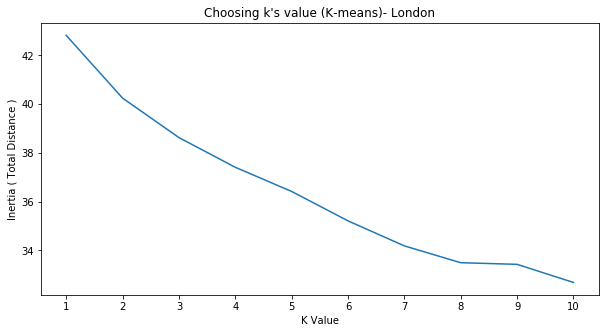

In [34]:
fig, axs =  plt.subplots(1,1, figsize=(10,5))
axs.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.title("Choosing k's value (K-means)- London")
plt.show()
fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/London_K-means.png')

In [36]:
# set number of clusters
kclusters = 8

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 5, 6, 2, 5, 1, 5, 6], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey,Grocery Store,Coffee Shop,Sushi Restaurant,Café,Bar,Lebanese Restaurant,Noodle House,Bus Stop,Liquor Store,Asian Restaurant
1,Abbey Road,Café,Deli / Bodega,Coffee Shop,Recording Studio,Sandwich Place,Pilates Studio,Turkish Restaurant,Gym / Fitness Center,Grocery Store,Gift Shop
2,Abingdon,Café,Pub,Clothing Store,Italian Restaurant,Burger Joint,Bakery,Breakfast Spot,Cupcake Shop,Tennis Court,Gift Shop
3,Acton Central,Grocery Store,Hotel,Breakfast Spot,Bed & Breakfast,Park,Train Station,Indian Restaurant,Flower Shop,Flea Market,Eastern European Restaurant
4,Addiscombe East,Grocery Store,Park,Fast Food Restaurant,Bakery,Café,Indian Restaurant,Pub,Chinese Restaurant,Diner,Eastern European Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
383,Woodberry Down,Café,Bus Stop,Pizza Place,Pub,Fast Food Restaurant,Convenience Store,Organic Grocery,Metro Station,Performing Arts Venue,Bagel Shop
384,Woodside,Grocery Store,Gym / Fitness Center,Park,Train Station,Construction & Landscaping,Portuguese Restaurant,Restaurant,Café,Bus Stop,Fast Food Restaurant
385,Woolwich Common,Bus Stop,Stationery Store,Farmers Market,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
386,Woolwich Riverside,Fast Food Restaurant,Café,Train Station,Farmers Market,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit


In [38]:
london_postcode_df

,Borough,Neighborhood,Latitude_avg,Longitude_avg
0,Lewisham,Whitefoot,51.435314,-0.005240
1,Lambeth,Streatham South,51.416389,-0.132432
2,Bromley,Darwin,51.321934,0.035867
3,Bromley,Penge and Cator,51.410205,-0.052140
4,Bromley,Clock House,51.406121,-0.050188
...,...,...,...,...
394,Westminster,Lancaster Gate,51.512920,-0.185636
395,Ealing,Acton Central,51.513513,-0.269329
396,Ealing,Southfield,51.500007,-0.261749
397,Hounslow,Turnham Green,51.491676,-0.264433


In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_merged = london_postcode_df
london_merged = london_merged.rename(columns={'Ward':'Neighborhood'})
#merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
london_merged = london_merged.dropna()
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)

london_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude_avg,Longitude_avg,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,Whitefoot,51.435314,-0.005240,7,History Museum,Indian Restaurant,Park,Zoo Exhibit,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
1,Lambeth,Streatham South,51.416389,-0.132432,1,Platform,Supermarket,Coffee Shop,Grocery Store,Gastropub,Pub,River,Burger Joint,Fabric Shop,Exhibit
2,Bromley,Darwin,51.321934,0.035867,6,Construction & Landscaping,Museum,Airport Terminal,Café,Zoo Exhibit,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
3,Bromley,Penge and Cator,51.410205,-0.052140,1,Supermarket,Pub,Pizza Place,Grocery Store,Italian Restaurant,Shopping Mall,Tram Station,Tapas Restaurant,Coffee Shop,Furniture / Home Store
4,Bromley,Clock House,51.406121,-0.050188,7,Train Station,Gastropub,Park,Tram Station,Convenience Store,Food,Flower Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude_avg'], london_merged['Longitude_avg'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [41]:
def plotting_cluster(cluster):
    # get all venues from cluster dataframe and convert to list
    venues = [item for sublist in cluster.iloc[:,1:].values.tolist() for item in sublist]
    #create dictionary with key: category venue and value: frequency of the category venues.
    venues_dict = {i:venues.count(i) for i in set(venues)}
    #sorted by value descdending the dict
    venues_dict = {r: venues_dict[r] for r in sorted(venues_dict, key=venues_dict.get, reverse=True)}
    venues_30 = {key:value for key,value in list(venues_dict.items())[0:30]}
    #create a dataframe with name category and frequency
    column_names = ['Venues_30', 'freq'] 
    df = pd.DataFrame(columns=column_names)
    df['venues_30'] = list(venues_30.keys())
    df['freq'] = list(venues_30.values()) 
    
    #Plots
    fig, axs = plt.subplots(2,1,figsize=(10,15))
    plt.subplots_adjust(hspace=-0.3)
    #plot bar
    sns.barplot(x='freq', y="venues_30", data=df, ax = axs[1])
    axs[1].set(title='the 30 most number of venues')
    #plot wordcloud
    wc = WordCloud(background_color="white",width=2600, height=600)
    wc.generate(str(venues))
    axs[0].imshow(wc, interpolation='bilinear')
    axs[0].axis("off")
    axs[0].set(title='venues from cluster')
    plt.show()

#### Cluster 1

In [42]:
cluster_1 = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Park Hill & Whitgift,Candy Store,Zoo Exhibit,Fast Food Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant


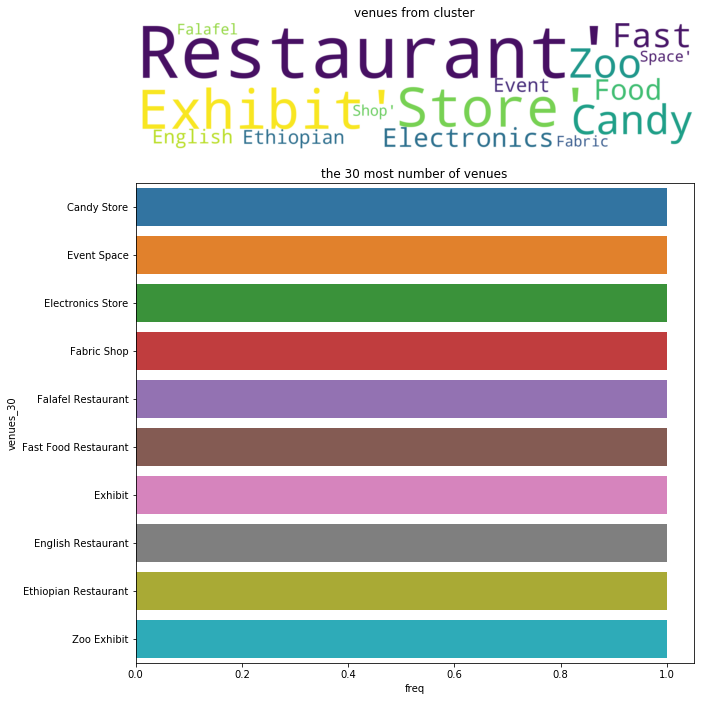

In [43]:
plotting_cluster(cluster_1)

#### Cluster 2

In [44]:
cluster_2 = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Streatham South,Platform,Supermarket,Coffee Shop,Grocery Store,Gastropub,Pub,River,Burger Joint,Fabric Shop,Exhibit
3,Penge and Cator,Supermarket,Pub,Pizza Place,Grocery Store,Italian Restaurant,Shopping Mall,Tram Station,Tapas Restaurant,Coffee Shop,Furniture / Home Store
6,West Wickham,Health & Beauty Service,Furniture / Home Store,Business Service,Zoo Exhibit,Farmers Market,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
7,King's Cross,Coffee Shop,Café,Hotel,Burger Joint,Hotel Bar,Bakery,Portuguese Restaurant,Pub,Garden,Vietnamese Restaurant
8,New Addington South,Grocery Store,Convenience Store,Coffee Shop,Lawyer,Bakery,Food,Flower Shop,Eastern European Restaurant,Food Stand,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...
389,Walpole,Pub,Pizza Place,Italian Restaurant,Coffee Shop,Wine Bar,Persian Restaurant,Park,Gym / Fitness Center,Hotel,Café
390,Ealing Broadway,Coffee Shop,Bakery,Clothing Store,Pizza Place,Vietnamese Restaurant,Hotel,Burger Joint,Thai Restaurant,Park,Bed & Breakfast
392,West End,Clothing Store,Boutique,Art Gallery,Women's Store,Cosmetics Shop,French Restaurant,Indian Restaurant,Lingerie Store,Cocktail Bar,Jewelry Store
393,South Acton,Pub,Museum,Fish & Chips Shop,Park,Tennis Court,Auto Garage,Fast Food Restaurant,Pizza Place,Kebab Restaurant,Art Gallery


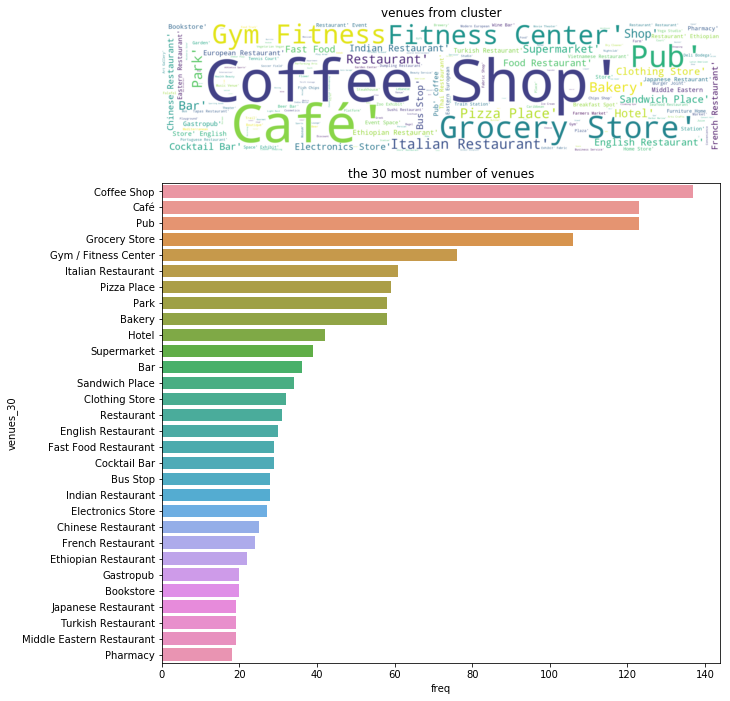

In [45]:
plotting_cluster(cluster_2)

#### Cluster 3

In [46]:
cluster_3 = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,New Addington North,Tram Station,Pub,Home Service,Farmers Market,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space
19,Addiscombe West,Grocery Store,Pub,South Indian Restaurant,Park,Business Service,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space
38,St Dunstan's,Bakery,Pub,Athletics & Sports,Canal Lock,Park,Farm,Farmers Market,Electronics Store,English Restaurant,Ethiopian Restaurant
58,Wanstead Village,Pub,Indian Restaurant,Irish Pub,Fast Food Restaurant,Italian Restaurant,Supermarket,Grocery Store,Food,Food & Drink Shop,Eastern European Restaurant
65,Wall End,Gym Pool,Pub,Sandwich Place,Bus Station,Indian Restaurant,Food,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
94,Wood Street,Pub,Brewery,Coffee Shop,Restaurant,Italian Restaurant,Distillery,Pizza Place,Farmers Market,Café,Art Gallery
98,Bromley South,Pub,Gym,Farmers Market,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
102,Cazenove,Bar,Pub,Cosmetics Shop,Supermarket,Fast Food Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
122,Hoxton West,Pub,Coffee Shop,Café,Hotel,Art Gallery,Breakfast Spot,Spa,Burger Joint,French Restaurant,Fast Food Restaurant
153,Highgate,Pub,Café,Italian Restaurant,Bakery,Mediterranean Restaurant,Historic Site,Deli / Bodega,Coffee Shop,Farmers Market,Bus Stop


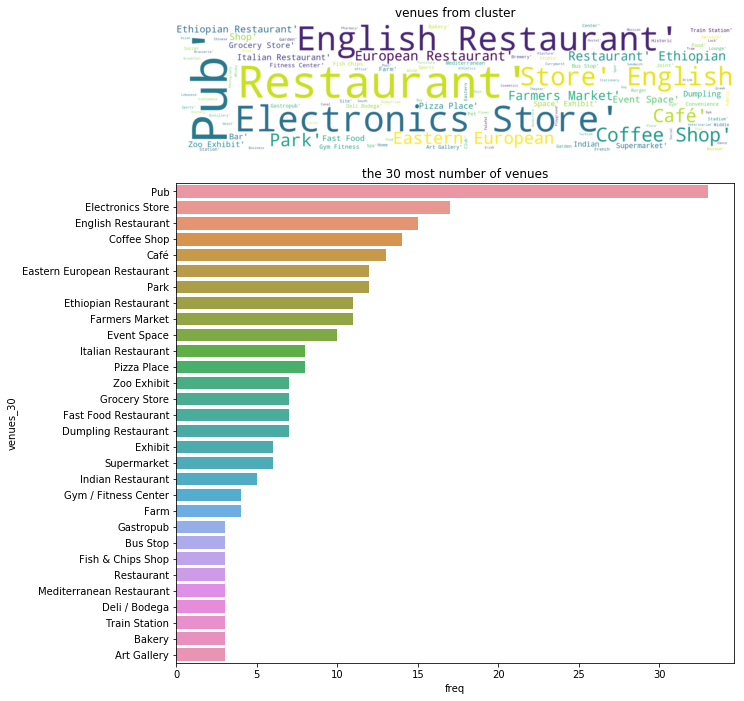

In [47]:
plotting_cluster(cluster_3)

#### Cluster 4

In [48]:
cluster_4 = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,West Thornton,Hotel,Bus Stop,Fast Food Restaurant,Sporting Goods Shop,Auto Garage,Supermarket,Bus Station,Zoo Exhibit,English Restaurant,Ethiopian Restaurant
28,Figge's Marsh,Supermarket,Train Station,Park,Bus Stop,Farm,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space
91,William Morris,Fast Food Restaurant,Clothing Store,Pub,Bus Stop,Gas Station,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
97,Bromley North,Bus Stop,Pub,Burger Joint,Light Rail Station,Hotel,Coffee Shop,Art Gallery,Office,Locksmith,Convenience Store
157,White Hart Lane,Bus Stop,Food & Drink Shop,Museum,Fish & Chips Shop,Café,Zoo Exhibit,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
202,Welsh Harp,Harbor / Marina,Fast Food Restaurant,Bus Stop,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
210,Golders Green,Bus Stop,Grocery Store,Cosmetics Shop,Coffee Shop,Supermarket,Metro Station,Beer Garden,Market,Pizza Place,Argentinian Restaurant
211,Childs Hill,Sushi Restaurant,Park,Hotel,Bus Stop,Zoo Exhibit,Farmers Market,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space
212,West Hendon,Coffee Shop,Bus Stop,Indian Restaurant,Supermarket,Gas Station,Platform,Pet Store,Costume Shop,Reservoir,Cuban Restaurant
228,Fryent,Bus Stop,Ice Cream Shop,Hardware Store,Hotel,Hookah Bar,Asian Restaurant,Park,Farm,Eastern European Restaurant,Electronics Store


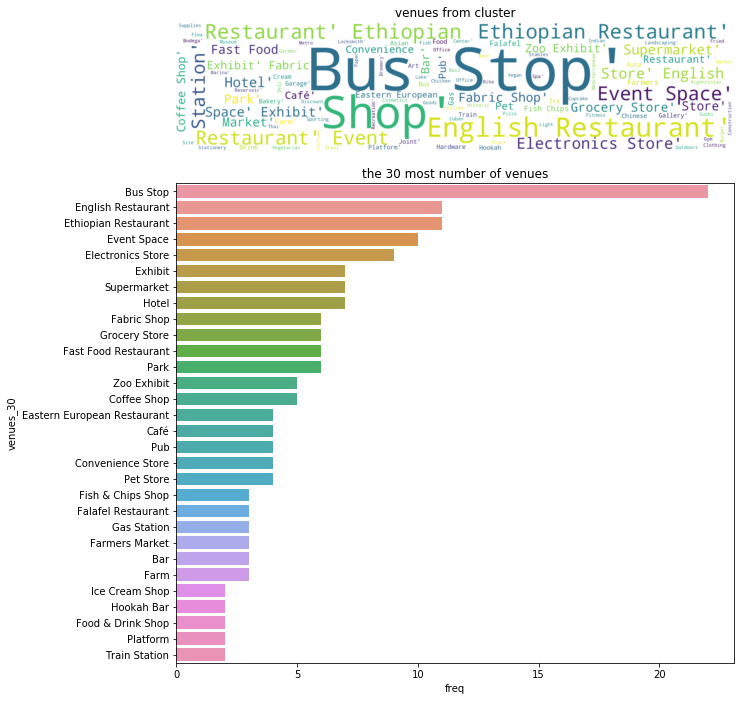

In [49]:
plotting_cluster(cluster_4)

#### Cluster 5

In [50]:
cluster_5 = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
364,South Richmond,Wine Shop,Zoo Exhibit,Fast Food Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop


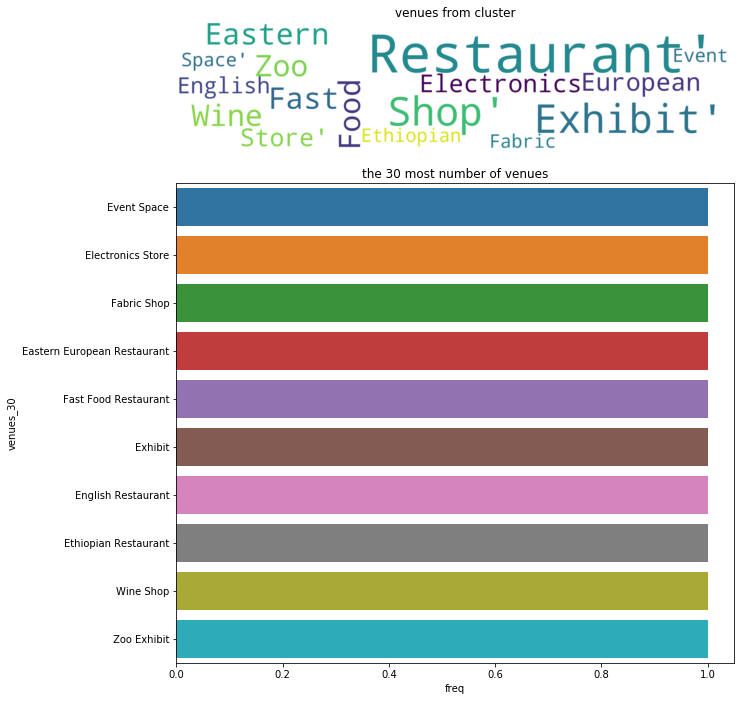

In [51]:
plotting_cluster(cluster_5)

#### Cluster 6

In [52]:
cluster_6 = london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_6.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Cricket Green,Tram Station,Garden,Convenience Store,Costume Shop,Coworking Space,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
37,Whitechapel,Hotel,Indian Restaurant,Grocery Store,Coffee Shop,Pub,Sandwich Place,Camera Store,Bakery,Creperie,Burger Joint
40,Spitalfields & Banglatown,Coffee Shop,Hotel,Café,Indian Restaurant,Cocktail Bar,Flea Market,Turkish Restaurant,Art Gallery,French Restaurant,Korean Restaurant
47,Aldgate,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Sandwich Place,Garden,Wine Bar,English Restaurant,Italian Restaurant,Restaurant
48,Tower,Hotel,Coffee Shop,Gym / Fitness Center,Garden,Beer Bar,Salad Place,Falafel Restaurant,Restaurant,Wine Bar,French Restaurant


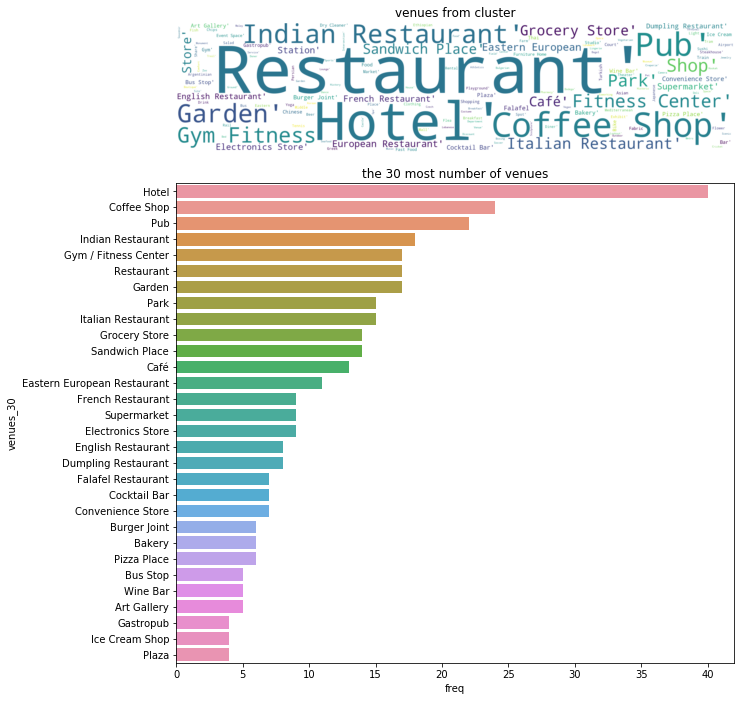

In [53]:
plotting_cluster(cluster_6)

#### Cluster 7

In [54]:
cluster_7 = london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_7.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Darwin,Construction & Landscaping,Museum,Airport Terminal,Café,Zoo Exhibit,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
11,Broad Green,Rental Car Location,Café,Sporting Goods Shop,Advertising Agency,Gas Station,Tram Station,Grocery Store,Supermarket,Zoo Exhibit,Event Space
21,Addiscombe East,Grocery Store,Park,Fast Food Restaurant,Bakery,Café,Indian Restaurant,Pub,Chinese Restaurant,Diner,Eastern European Restaurant
24,Biggin Hill,Grocery Store,Café,Construction & Landscaping,Zoo Exhibit,Farmers Market,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
32,Ravensbury,Trail,Park,Café,Soccer Stadium,Falafel Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space


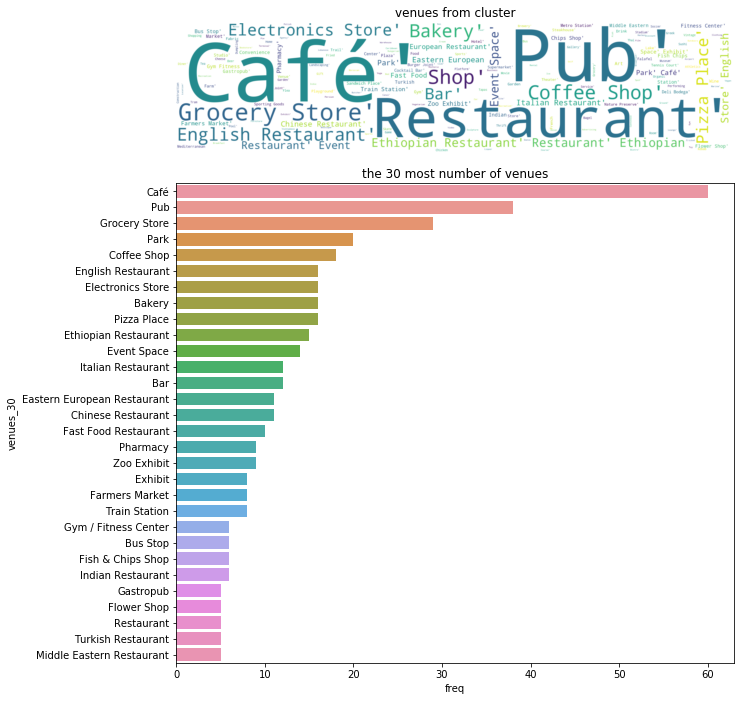

In [55]:
plotting_cluster(cluster_7)

#### Cluster 8

In [56]:
cluster_8 = london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
cluster_8.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Whitefoot,History Museum,Indian Restaurant,Park,Zoo Exhibit,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
4,Clock House,Train Station,Gastropub,Park,Tram Station,Convenience Store,Food,Flower Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
5,Hayes and Coney Hall,Park,Zoo Exhibit,Farmers Market,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
20,South Croydon,Tram Station,Golf Course,Park,Beer Garden,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
27,Pollards Hill,Convenience Store,Park,Miscellaneous Shop,Food Court,Food & Drink Shop,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit


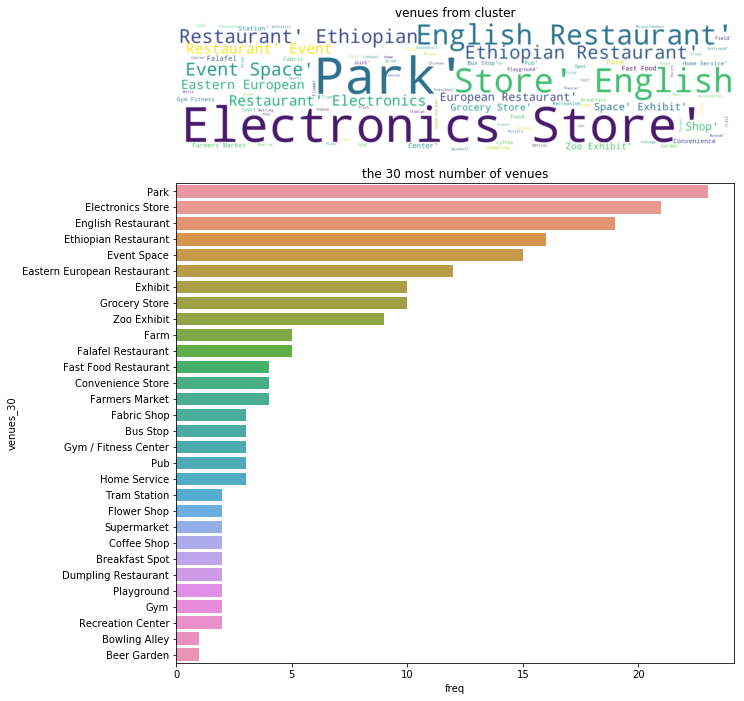

In [57]:
plotting_cluster(cluster_8)